In [1]:
from BPTK_Py import Model, bptk
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 1) Model initialization
model = Model(starttime=0.0, stoptime=50.0, dt=0.1, name="ants_sd_clean")

# 2) Stocks + initial values
A = model.stock("A")  # Ameisen
A.initial_value = 0.5
H = model.stock("H")  # Habitat
H.initial_value = 0.6
S = model.stock("S")  # Schädlinge
S.initial_value = 0.5
I = model.stock("I")  # Invasive
I.initial_value = 0.2
W = model.stock("W")  # Waldstabilität
W.initial_value = 0.8
N = model.stock("N")  # Nistplätze
N.initial_value = 0.5
E = model.stock("E")  # Ökosystemleistungen
E.initial_value = 0.6

In [3]:
# 3) Constants (simplified names)
const_vals = {
    # Ameisen
    "rA": 0.8, "mA": 0.15, "pA": 0.05, "cAS": 0.12,
    # Schädlinge
    "rS": 0.6, "kAS": 0.9, "uP": 0.5,
    # Habitat
    "alp": 0.3, "bet": 0.25, "gam": 0.2, "delSH": 0.15,
    # Invasive
    "rI": 0.3, "compAI": 0.35, "climI": 0.3,
    # Wald & Leistungen
    "om": 0.25, "xiE": 0.3, "chi": 0.1,
    # Saturation constants
    "hhalf": 0.3, "nhalf": 0.4
}

C = {}
for k, v in const_vals.items():
    C[k] = model.constant(k)
    C[k].equation = v

In [4]:
# 4) Scenario drivers (can be overridden)
NS = model.constant("NS");       NS.equation = 0.4   # Naturschutz
FRAG = model.constant("FRAG");   FRAG.equation = 0.5 # Fragmentierung
KLIMA = model.constant("KLIMA"); KLIMA.equation = 0.4 # Klimastress
PESTI = model.constant("PESTI"); PESTI.equation = 0.4 # Pestizideinsatz

In [5]:
# 5) Helper (Saturation functions)
fH = model.converter("fH"); fH.equation = H / (H + C["hhalf"])
fN = model.converter("fN"); fN.equation = N / (N + C["nhalf"])

In [6]:
# 6) Direct rate equations (no growth_/loss_ Converter!)
dA = model.converter("dA")
dA.equation = C["rA"]*A*fH*fN - (C["mA"] + C["pA"]*PESTI)*A - C["cAS"]*A*S - C["compAI"]*I*A

dH = model.converter("dH")
dH.equation = C["alp"]*NS - C["bet"]*FRAG - C["gam"]*KLIMA - C["delSH"]*S*H

dS = model.converter("dS")
dS.equation = C["rS"]*S - C["kAS"]*A*S - C["uP"]*PESTI*S

dI = model.converter("dI")
dI.equation = C["rI"]*I + C["climI"]*KLIMA - 0.3*A*I

dW = model.converter("dW")
dW.equation = C["om"]*H*A - C["chi"]*KLIMA*W

dN = model.converter("dN")
dN.equation = 0.6*H - 0.2*N

dE = model.converter("dE")
dE.equation = C["xiE"]*A - 0.1*E

# Link stocks to their rate converters
A.equation = dA
H.equation = dH
S.equation = dS
I.equation = dI
W.equation = dW
N.equation = dN
E.equation = dE

In [7]:
# 7) bptk facade + scenarios
b = bptk()
b.register_model(model)
b.regisb = bptk()
b.register_model(model)

base_constants = {**const_vals, "NS": 0.4, "FRAG": 0.5, "KLIMA": 0.4, "PESTI": 0.4}
b.register_scenario_manager({"smAnts": {"model": model, "base_constants": base_constants}})

scenarios = {
    "Baseline": {"constants": {}},
    "Naturschutz_plus": {"constants": {"NS": 0.8, "PESTI": 0.3}},
    "Weniger_Pestizide": {"constants": {"PESTI": 0.1}},
    "Mehr_KlimaStress": {"constants": {"KLIMA": 0.8}},
    "Fragmentierung_hoch": {"constants": {"FRAG": 0.8}},
}
b.register_scenarios(scenarios, scenario_manager="smAnts")

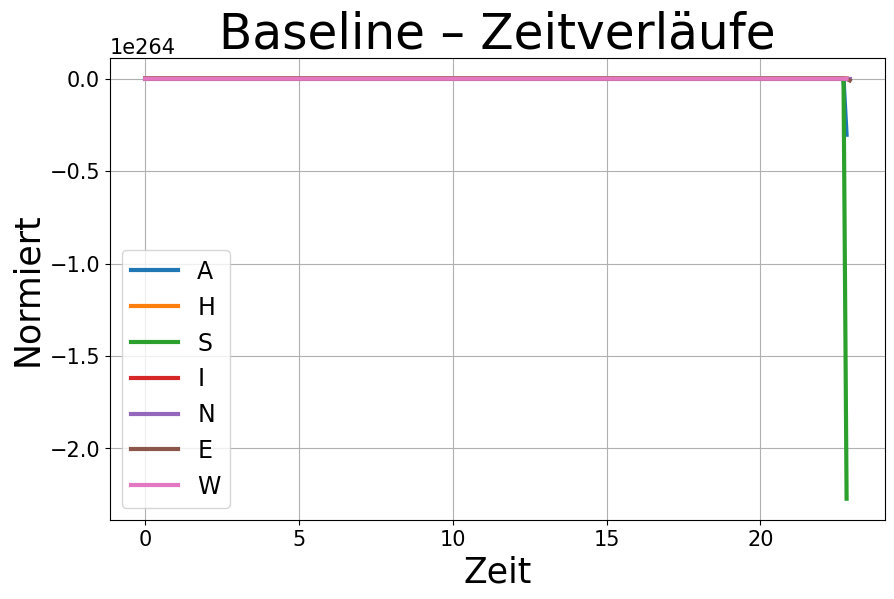

In [8]:
# 8) Baseline run (executes the simulation)
df_base = b.plot_scenarios(
    scenarios="Baseline",
    scenario_managers="smAnts",
    equations=["A", "H", "S", "I", "N", "E", "W"],
    return_df=True
)

ax = df_base[["A","H","S","I","N","E","W"]].plot(figsize=(10,6), title="Baseline – Zeitverläufe")
ax.set_xlabel("Zeit"); ax.set_ylabel("Normiert"); ax.grid(True)
plt.show()